In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import gc

In [10]:
df = pd.read_csv('mpii_dataset.csv')

class KeypointsDataset(Dataset):
    def __init__(self, df, images_dir, transform=None):
        self.df = df
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df['NAME'][idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        image_width, image_height = image.size

        keypoints = []
        for px in range(2, 34, 2):
            x = self.df.iloc[idx, px] / image_width
            y = self.df.iloc[idx, px + 1] / image_height
            keypoints.append([x, y])
        keypoints = np.array(keypoints, dtype=np.float32).flatten()

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(keypoints, dtype=torch.float32)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

images_dir = 'MPII/images'
dataset = KeypointsDataset(df, images_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=16)

In [11]:
class ComplexNet(nn.Module):
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 7 * 7, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 32)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ComplexNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    for epoch in trange(num_epochs, desc="Epochs"):
        train_loss = 0.0
        model.train()

        for inputs, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=True):
            inputs = inputs.to(device, dtype=torch.float32)
            targets = targets.to(device, dtype=torch.float32)

            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}')
        
        torch.cuda.empty_cache()
        gc.collect()

    print('Finished Training')

train_model(model, criterion, optimizer, train_loader, num_epochs=25)


Epochs:   4%|███                                                                         | 1/25 [00:24<09:51, 24.65s/it]

Epoch: 1 	Training Loss: 6.217704



Epochs:   8%|██████                                                                      | 2/25 [00:49<09:29, 24.76s/it]

Epoch: 2 	Training Loss: 0.065044



Epochs:  12%|█████████                                                                   | 3/25 [01:14<09:05, 24.77s/it]

Epoch: 3 	Training Loss: 0.059469



Epochs:  16%|████████████▏                                                               | 4/25 [01:39<08:40, 24.79s/it]

Epoch: 4 	Training Loss: 0.055863



Epochs:  20%|███████████████▏                                                            | 5/25 [02:03<08:16, 24.80s/it]

Epoch: 5 	Training Loss: 0.052215



Epochs:  24%|██████████████████▏                                                         | 6/25 [02:28<07:50, 24.78s/it]

Epoch: 6 	Training Loss: 0.047695



Epochs:  28%|█████████████████████▎                                                      | 7/25 [02:53<07:25, 24.77s/it]

Epoch: 7 	Training Loss: 0.046273



Epochs:  32%|████████████████████████▎                                                   | 8/25 [03:18<07:01, 24.77s/it]

Epoch: 8 	Training Loss: 0.046071



Epochs:  36%|███████████████████████████▎                                                | 9/25 [03:42<06:36, 24.75s/it]

Epoch: 9 	Training Loss: 0.045964



Epochs:  40%|██████████████████████████████                                             | 10/25 [04:07<06:11, 24.76s/it]

Epoch: 10 	Training Loss: 0.046034



Epochs:  44%|█████████████████████████████████                                          | 11/25 [04:32<05:46, 24.76s/it]

Epoch: 11 	Training Loss: 0.045931



Epochs:  48%|████████████████████████████████████                                       | 12/25 [04:57<05:22, 24.77s/it]

Epoch: 12 	Training Loss: 0.045896



Epochs:  52%|███████████████████████████████████████                                    | 13/25 [05:22<04:57, 24.80s/it]

Epoch: 13 	Training Loss: 0.045761



Epochs:  56%|██████████████████████████████████████████                                 | 14/25 [05:46<04:32, 24.79s/it]

Epoch: 14 	Training Loss: 0.045777



Epochs:  60%|█████████████████████████████████████████████                              | 15/25 [06:11<04:08, 24.81s/it]

Epoch: 15 	Training Loss: 0.045714



Epochs:  64%|████████████████████████████████████████████████                           | 16/25 [06:36<03:43, 24.87s/it]

Epoch: 16 	Training Loss: 0.045640



Epochs:  68%|███████████████████████████████████████████████████                        | 17/25 [07:01<03:18, 24.86s/it]

Epoch: 17 	Training Loss: 0.045618



Epochs:  72%|██████████████████████████████████████████████████████                     | 18/25 [07:26<02:54, 24.88s/it]

Epoch: 18 	Training Loss: 0.045585



Epochs:  76%|█████████████████████████████████████████████████████████                  | 19/25 [07:51<02:29, 24.87s/it]

Epoch: 19 	Training Loss: 0.045526



Epochs:  80%|████████████████████████████████████████████████████████████               | 20/25 [08:16<02:04, 24.87s/it]

Epoch: 20 	Training Loss: 0.045460



Epochs:  84%|███████████████████████████████████████████████████████████████            | 21/25 [08:41<01:39, 24.90s/it]

Epoch: 21 	Training Loss: 0.045396



Epochs:  88%|██████████████████████████████████████████████████████████████████         | 22/25 [09:06<01:14, 24.91s/it]

Epoch: 22 	Training Loss: 0.045425



Epochs:  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [09:31<00:49, 24.90s/it]

Epoch: 23 	Training Loss: 0.045369



Epochs:  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [09:55<00:24, 24.92s/it]

Epoch: 24 	Training Loss: 0.045378



Epochs: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [10:21<00:00, 24.86s/it]

Epoch: 25 	Training Loss: 0.045366
Finished Training


In [13]:
def test_model(model, test_loader):
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device, dtype=torch.float32)
            targets = targets.to(device, dtype=torch.float32)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
        
        torch.cuda.empty_cache()
        gc.collect()

    average_loss = total_loss / len(test_loader.dataset)
    print('Average keypoint error (MSE) on test images: {:.6f}'.format(average_loss))

test_model(model, val_loader)

torch.save(model.state_dict(), 'model_weights.pth')


Testing: 100%|████████████████████████████████████████████████████████████████████████| 109/109 [00:06<00:00, 16.76it/s]


Average keypoint error (MSE) on test images: 0.043666


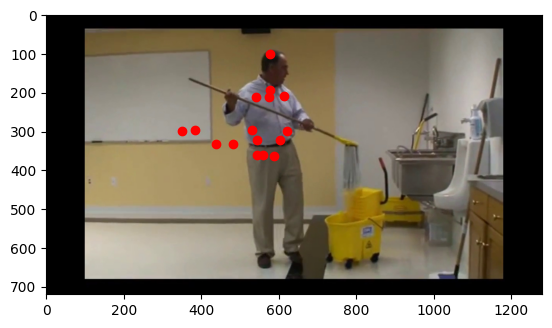

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    return image

def predict_keypoints(model, image_path):
    model.eval()
    image = load_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(image)
        keypoints = outputs.cpu().numpy().flatten()
    
    image = Image.open(image_path)
    image_width, image_height = image.size
    keypoints[0::2] *= image_width
    keypoints[1::2] *= image_height
    return keypoints

def visualize_keypoints(image_path, keypoints, shift_x=0, shift_y=0):
    image = Image.open(image_path)
    plt.imshow(image)
    for i in range(0, len(keypoints), 2):
        plt.scatter(keypoints[i] - shift_x, keypoints[i+1] - shift_y, color='red')
    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ComplexNet()
model.load_state_dict(torch.load('model_weights.pth'))
model = model.to(device)

image_path = 'MPII/images/000502550.jpg'
predicted_keypoints = predict_keypoints(model, image_path)
visualize_keypoints(image_path, predicted_keypoints, shift_x=35, shift_y=50)
# May now need to manually move prediction point locations
# That is for the future step

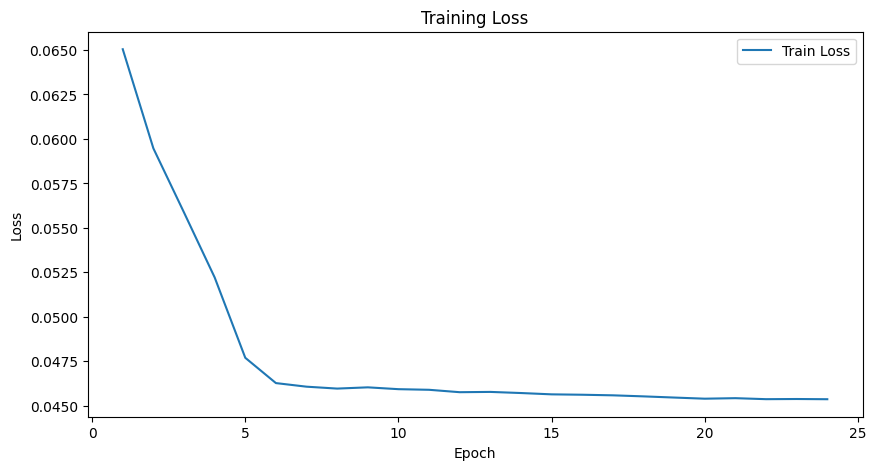

In [4]:
import matplotlib.pyplot as plt

def show_final_history(training_losses):
    epochs = list(range(1, len(training_losses) + 1))
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_title('Training Loss')
    ax.plot(epochs, training_losses, label="Train Loss")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()
    
show_final_history(training_losses)